# Running pyqz I

This page is also available as an IPython notebook (``pyqz_demo_basic.ipynb``) included with the code and located in ``pyqz/examples/``.

<i>Note: the code syntax in v0.8.0 has changed significantly, and so did the function calls. pyqz v0.8.x is therefore NOT backward compatible with older pyqz versions.</i>

<i><span style="color:red">Warning: the examples below will show you how to run the main functions inside pyqz. <b>But these do not exempt you from getting acquainted with the "Understanding pyqz" section of the documentation !</b></span></i>


### A) Installing and importing pyqz

Installing pyqz is easy. Download it from Github, unpack it anywhere you like, and make sure that this location is in your Python path. You should then be able to import the package and check its version from within any Python shell:

In [5]:
%matplotlib inline
import pyqz

import numpy as np

From v0.8.0 onwards, the plotting functions have been separated in a distinct module, which must be import separately, if you wish to exploit them. 

In [6]:
import pyqz_plots

### B) accessing MAPPINGS line ratio diagnostic grids

pyqz gives you easy access to the latest MAPPINGS strong nebular line ratio diagnostic diagrams (and associated info on the MAPPINGS version used to generate the grid, etc...). This can for example be useful to create your own line ratio diagnostic plots. You can access the nodes of any line ratio diagram using ``pyqz.get_grid()``:

In [7]:
a_grid = pyqz.get_grid('[NII]/[SII]+;[OIII]/[SII]+', sampling=1)

The main parameters of the MAPPINGS simulations can be specified via the following keywords:
  - ``Pk`` let's you define the pressure of the simulated HII regions,
  - ``struct`` allows you to choose between plane-parallel (``'pp'``) and spherical (``'sph'``) HII regions, and
  - ``kappa`` lets you define the value of $\kappa$ (from the so-called $\kappa$-distribution).
 
<b>All these values must match an existing set of MAPPINGS simulations inside the ``pyqz/reference_data/`` folder, or pyqz will issue an error. In other words, pyqz will not be running new MAPPINGS simulations for you.</b>

So, if one wanted to access the MAPPINGS simulations for plane-parallel HII regions, with Maxwell-Boltzmann electron density distribution, ``Pk =5.0`` (these are the default parameters), one should type:

In [8]:
a_grid = pyqz.get_grid('[NII]/[SII]+;[OIII]/[SII]+', struct = 'pp', Pk = 5, kappa = 'inf')

If you want to check how a given line ratio diagnostic diagram looks (and e.g. check whether the MAPPINGS grid is flat, or wrapped) for line ratios of your choice, you can use ``pyqz_plots.plot_grid()``:

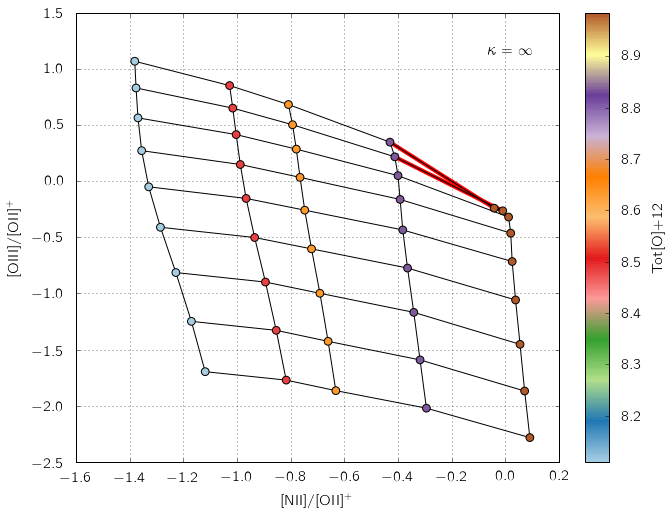

In [9]:
pyqz_plots.plot_grid('[NII]/[OII]+;[OIII]/[OII]+', struct = 'pp', Pk = 5, kappa = 'inf')

You can check which version of MAPPINGS was used to generate the grids currently inside pyqz as follows:

In [16]:
fn = pyqz.pyqz_tools.get_MVphotogrid_fn(Pk = 5.0, calibs = 'GCZO', kappa = np.inf, struct = 'pp', sampling = 1)
info = pyqz.pyqz_tools.get_MVphotogrid_metadata(fn)

print 'MAPPINGS id: %s' % info['MV_id']
print 'Model created: %s' % info['date']
print 'Model parameters: %s' % info['params'].split(': ')[1]

MAPPINGS id: MAPPINGS V HII Region Grid: QZ pp_GCZO_Pk50_kinf
Model created: Thu Dec 10 14:16:36 CLST 2015
Model parameters: pp,two,LPk=5.0,dep=Depln_Fe_1.50.txt,kap=inf,GCZFea05t2,SF=cont,a05,isp,#11,P6,Mv5.0.16,Svm802,FE15


An important feature of pyqz is the auto-detection of wraps in the diagnostic grids, marked with red segments in the diagram, and returned as an array by the function ``pyqz.check_grid()``.

The <i>default</i> MAPPINGS grids shipped with pyqz are coarse. For various reasons better explained elsewhere (see the MAPPINGS documentation), only a few abundance values have matching stellar tracks <b>AND</b> stellar atmospheres. Hence, only a few abundance points can be simulated in a consistent fashion. 

Rather than 1) interpolating between stellar tracks and stellar atmospheres in the abundance space and 2) running extra MAPPINGS models (which would use inconsistent & interpolated input), pyqz can directly <b>resample</b> each diagnostic grid (using the function ``pyqz_tools.refine_MVphotogrid()``, see the docs for more info). The resampling is performed in the {``LogQ`` and ``Tot[O+12]`` vs line ratio} space for all line ratios returned by MAPPINGS using Akima splines. Resampled grids can be accessed via the ``sampling`` keyword. Diagnostic grids resampled 2x2 times are shipped in the default pyqz package and are directly accessible, e.g.:

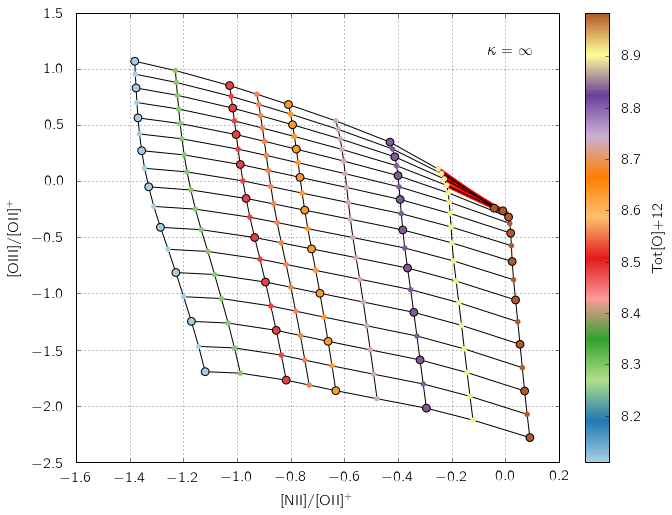

In [9]:
pyqz_plots.plot_grid('[NII]/[OII]+;[OIII]/[OII]+', struct = 'pp', Pk = 5, kappa = 'inf', sampling=2)

In the default pyqz diagrams, the <b>original</b> MAPPINGS nodes are circled with a black outline, while the <b>reconstructed</b> nodes are not. For grids more densely resampled, see the "Advanced use 2" below.


### C) deriving <code>LogQ</code> and <code>Tot[O+12]</code> for a given set of line ratios

At the core of pyqz lies ``pyqz.interp_qz()``, which is the basic routine used to interpolate a given line ratio diagnostic grid. The function is being fed by line ratios stored inside numpy arrays, and will only return a value for line ratios landing <b> on valid and un-wrapped</b> regions of the grid:

Tot[O]+12 = 8.67


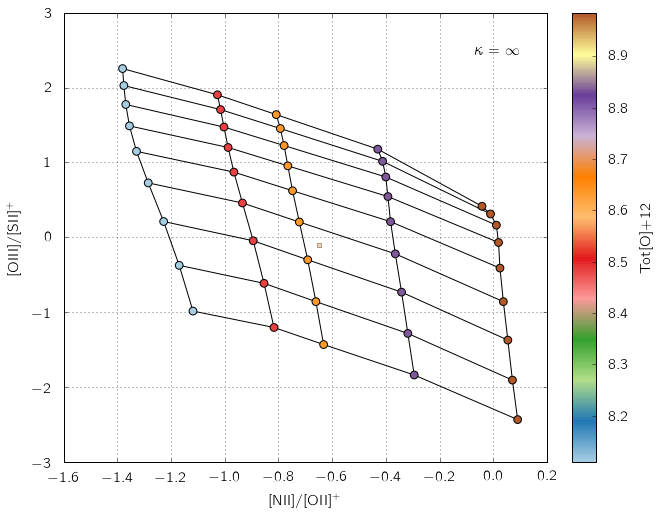

In [22]:
niioii = np.array([-0.65])
oiiisii = np.array([-0.1])
z = pyqz.interp_qz('Tot[O]+12',[niioii, oiiisii],'[NII]/[OII]+;[OIII]/[SII]+', 
                   sampling=1,struct='pp')
print 'Tot[O]+12 = %.2f' % z

# The result can be visualized using pyqz_plots.plot_grid()
pyqz_plots.plot_grid('[NII]/[OII]+;[OIII]/[SII]+',sampling = 1, struct='pp', data = [niioii,oiiisii], interp_data=z)

Of course, one usually wants to compute both ``LogQ`` and ``Tot[O+12]``or ``gas[O+12]`` for a large set of strong emission line fluxes, combining the estimates from different line ratio diagnostics diagrams. This is exactly what the function ``pyqz.get_global_qz()`` allows you to do. 

The function is being fed the individual line fluxes and associated errors in the form of numpy arrays and lists. ID tags for each dataset can also be given to the function (these are then used if/when saving the different diagrams to files). 

In [32]:
pyqz.get_global_qz(np.array([[ 1.00e+00, 5.00e-02, 2.38e+00, 1.19e-01, 5.07e+00, 2.53e-01, 
                               5.67e-01, 2.84e-02, 5.11e-01, 2.55e-02, 2.88e+00, 1.44e-01]]),
                   ['Hb','stdHb','[OIII]','std[OIII]','[OII]+','std[OII]+',
                    '[NII]','std[NII]','[SII]+','std[SII]+','Ha','stdHa'],
                   ['[NII]/[SII]+;[OIII]/Hb','[NII]/[OII]+;[OIII]/[SII]+'], 
                   ids = ['NGC_1234'],
                   KDE_method = 'multiv',
                   KDE_qz_sampling = 201j,
                   struct = 'pp',
                   sampling = 1,
                   verbose = True)

 
--> Received 1 spectrum ...
--> Dealing with them one at a time ... be patient now !
    (no status update until I am done ...)
 
All done in 0:00:00.570925


[array([[  7.38831887e+00,   8.48760006e+00,   7.37681443e+00,
           8.48372388e+00,   7.38256665e+00,   5.75221877e-03,
           8.48566197e+00,   1.93808636e-03,   7.40187112e+00,
           5.25153395e-02,   8.48403665e+00,   5.81923212e-02,
           7.38004469e+00,   2.91962544e-02,   8.48364792e+00,
           2.74853806e-02,   7.38278851e+00,   3.35428824e-02,
           8.48207392e+00,   3.32925610e-02,   0.00000000e+00,
           0.00000000e+00]]),
 ['[NII]/[SII]+;[OIII]/Hb|LogQ',
  '[NII]/[SII]+;[OIII]/Hb|Tot[O]+12',
  '[NII]/[OII]+;[OIII]/[SII]+|LogQ',
  '[NII]/[OII]+;[OIII]/[SII]+|Tot[O]+12',
  '<LogQ>',
  'std(LogQ)',
  '<Tot[O]+12>',
  'std(Tot[O]+12)',
  '[NII]/[SII]+;[OIII]/Hb|LogQ{KDE}',
  'err([NII]/[SII]+;[OIII]/Hb|LogQ{KDE})',
  '[NII]/[SII]+;[OIII]/Hb|Tot[O]+12{KDE}',
  'err([NII]/[SII]+;[OIII]/Hb|Tot[O]+12{KDE})',
  '[NII]/[OII]+;[OIII]/[SII]+|LogQ{KDE}',
  'err([NII]/[OII]+;[OIII]/[SII]+|LogQ{KDE})',
  '[NII]/[OII]+;[OIII]/[SII]+|Tot[O]+12{KDE}',
  'err(

By default, all line fluxes errors are assumed to be gaussian, where the input ``std`` value is the 1 standard deviation. Alternatively, line fluxes can be tagged as upper-limits by setting their errors to -1.

The outcome of ``get_global_qz()`` can be visualized using ``pyqz_plots.plot_global_qz()``, but only if ``KDE_pickle_loc`` is set in the first one. This keyword defines the location in which to save a ``pickle`` file that contains all the relevant pieces of information associated with a given function call, i.e.: the single and global KDE, the ``srs`` random realizations of the line fluxes, etc ...

 
--> Received 1 spectrum ...
--> Dealing with them one at a time ... be patient now !
    (no status update until I am done ...)
 
All done in 0:00:00.639897


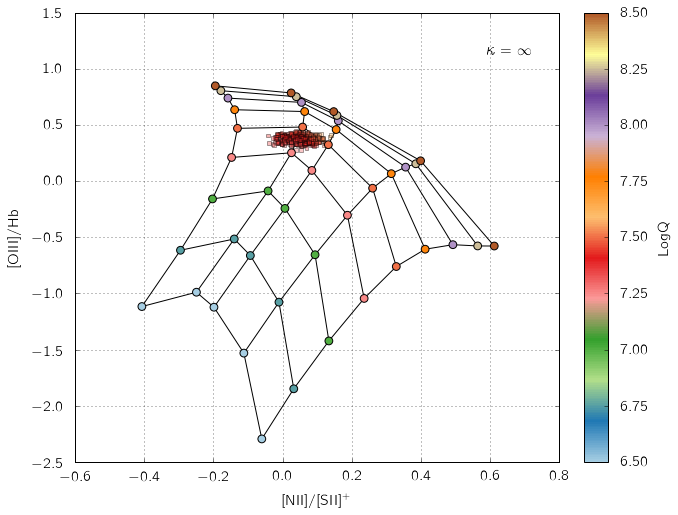

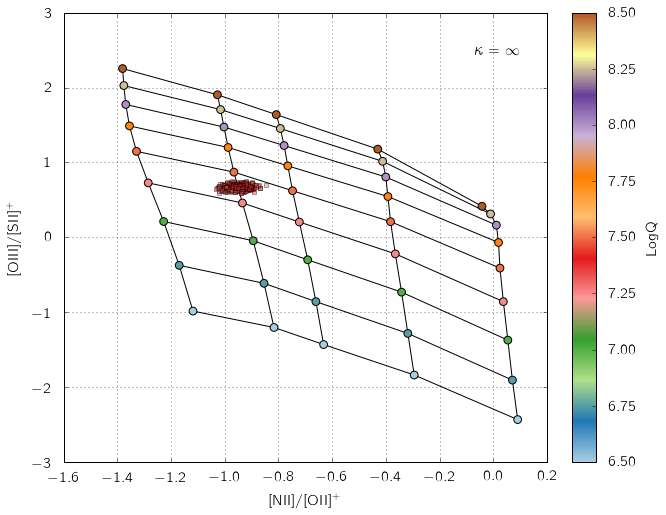

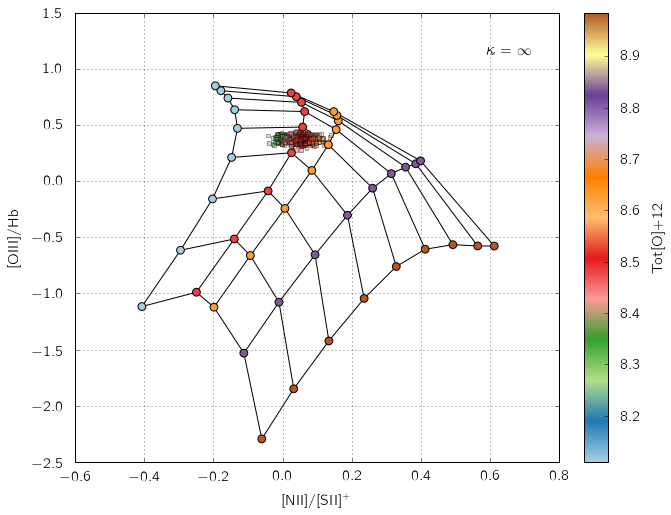

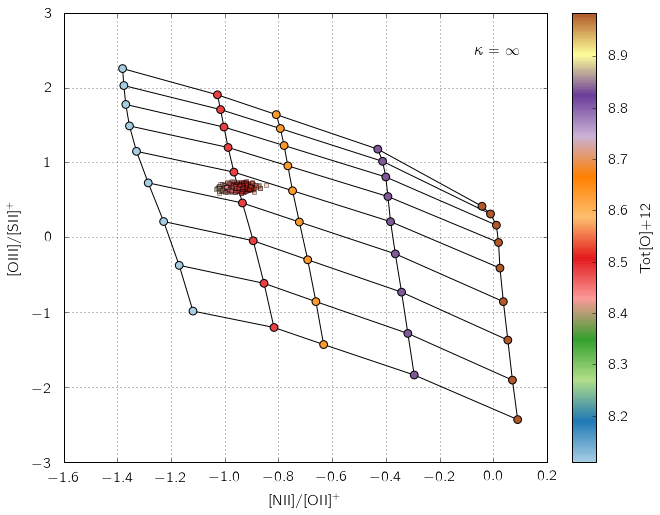

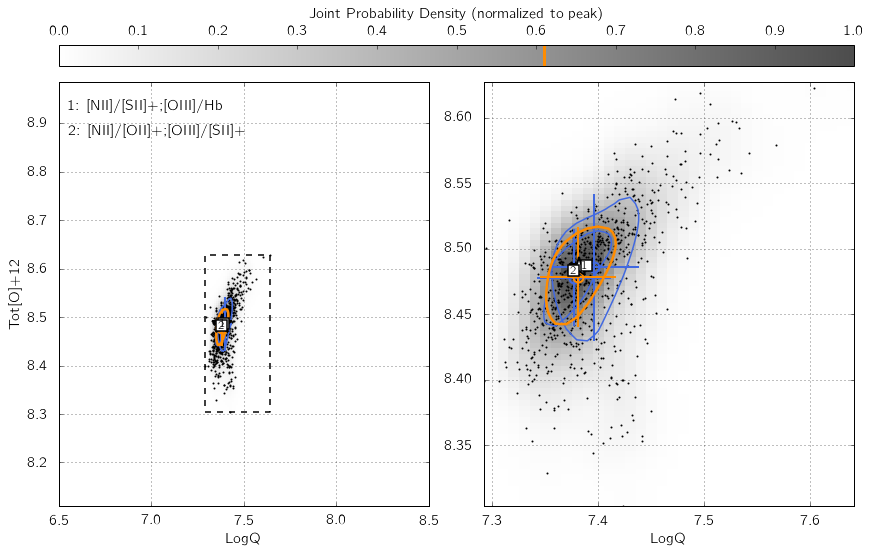

In [33]:
out = pyqz.get_global_qz(np.array([[ 1.00e+00, 5.00e-02, 2.38e+00, 1.19e-01, 5.07e+00, 2.53e-01, 
                                     5.67e-01, 2.84e-02, 5.11e-01, 2.55e-02, 2.88e+00, 1.44e-01]]),
                   ['Hb','stdHb','[OIII]','std[OIII]','[OII]+','std[OII]+',
                    '[NII]','std[NII]','[SII]+','std[SII]+','Ha','stdHa'],
                   ['[NII]/[SII]+;[OIII]/Hb','[NII]/[OII]+;[OIII]/[SII]+'], 
                   ids = ['NGC_1234'],
                   KDE_method = 'multiv',
                   KDE_qz_sampling = 201j,
                   KDE_pickle_loc = './example_plots/',
                   struct = 'pp',
                   sampling = 1,
                   verbose = True)

import glob
fn = glob.glob('./example_plots/*NGC_1234*.pkl')

# pyqz_plots.get_global_qz() takes the pickle filename as argument. 
pyqz_plots.plot_global_qz(fn[0], show_plots=True, save_loc = './example_plots', do_all_diags=True)

Users less keen on using Python extensively can alternatively feed their data to pyqz via an <b>appropriately structured</b> ``.csv`` file and receive another ``.csv`` file in return (as well as a numpy array):

In [34]:
pyqz.get_global_qz_ff('./example_input.csv', 
                      ['[NII]/[SII]+;[OIII]/Hb','[NII]/[OII]+;[OIII]/[SII]+'], 
                      struct='pp',
                      KDE_method='multiv',
                      KDE_qz_sampling = 201j,
                      sampling=1)

 
--> Received 1 spectrum ...
--> Dealing with them one at a time ... be patient now !
    (no status update until I am done ...)
 
All done in 0:00:00.521950


(array([[  7.38831887e+00,   8.48760006e+00,   7.37681443e+00,
           8.48372388e+00,   7.38256665e+00,   5.75221877e-03,
           8.48566197e+00,   1.93808636e-03,   7.40830999e+00,
           5.96592780e-02,   8.49102382e+00,   5.97711699e-02,
           7.38561173e+00,   2.66149396e-02,   8.48676873e+00,
           2.35291434e-02,   7.38608041e+00,   3.38911741e-02,
           8.48524692e+00,   3.24784930e-02,   0.00000000e+00,
           0.00000000e+00]]),
 ['[NII]/[SII]+;[OIII]/Hb|LogQ',
  '[NII]/[SII]+;[OIII]/Hb|Tot[O]+12',
  '[NII]/[OII]+;[OIII]/[SII]+|LogQ',
  '[NII]/[OII]+;[OIII]/[SII]+|Tot[O]+12',
  '<LogQ>',
  'std(LogQ)',
  '<Tot[O]+12>',
  'std(Tot[O]+12)',
  '[NII]/[SII]+;[OIII]/Hb|LogQ{KDE}',
  'err([NII]/[SII]+;[OIII]/Hb|LogQ{KDE})',
  '[NII]/[SII]+;[OIII]/Hb|Tot[O]+12{KDE}',
  'err([NII]/[SII]+;[OIII]/Hb|Tot[O]+12{KDE})',
  '[NII]/[OII]+;[OIII]/[SII]+|LogQ{KDE}',
  'err([NII]/[OII]+;[OIII]/[SII]+|LogQ{KDE})',
  '[NII]/[OII]+;[OIII]/[SII]+|Tot[O]+12{KDE}',
  'err(

The first line of the input file must contain the name of each column, following the pyqz convention. The order itself does not matter, e.g.:

`` Id,[OII]+,std[OII]+,Hb,stdHb,[OIII],std[OIII],[OI],std[OI],Ha,stdHa,[NII],std[NII],[SII]+,std[SII]+``

The ``Id`` (optional) can be used to add a tag (i.e. a string) to each set of line fluxes. This tag will be used in the filenames of the diagrams (if some are saved) and in the output ``.csv`` file as well. 

Commented line begin with ``#``, missing values are marked with ``$$$`` (set with the ``missing_values`` keyword), and the decimal precision in the output file is set with ``decimals`` (default=5).

**At this point, it must be stressed that ``pyqz.get_global_qz()`` can only exploit a finite set of diagnostic grids, namely:**

In [13]:
pyqz.diagnostics.keys()

['[NII]/[OII]+;[OIII]/[SII]+',
 '[NII]/[OII]+;[OIII]/[OII]+',
 '[NII]/[SII]+;[NII]/Ha;[OIII]/Hb',
 '[NII]/[SII]+;[OIII]/Hb',
 '[OIII]4363/[OIII];[OIII]/[SII]+',
 '[NII]/[SII]+;[OIII]/[OII]+',
 '[NII]/[OII]+;[SII]+/Ha',
 '[OIII]4363/[OIII];[SII]+/Ha',
 '[OIII]4363/[OIII];[OIII]/[OII]+',
 '[NII]/[SII]+;[OIII]/[SII]+']

These specific diagnostic diagrams are chosen to be largely flat, i.e. they are able to cleanly disentangle the influence of ``LogQ`` and ``Tot[O]+12``. One does not need to use all the grids together. For example, if one knows that an [OII] line flux measurement is corrupted, one ought to simply use the diagnostic grids that do not rely on this line to derive the estimates of ``LogQ`` and ``Tot[O]+12``.

Users can easily add new diagnostics to this list (defined inside ``pyqz_metadata.py``), but will do so at their own risk.